In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path = '../Wimbledon_featured_matches.csv'
df = pd.read_csv(path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7284 entries, 0 to 7283
Data columns (total 46 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   match_id            7284 non-null   object 
 1   player1             7284 non-null   object 
 2   player2             7284 non-null   object 
 3   elapsed_time        7284 non-null   object 
 4   set_no              7284 non-null   int64  
 5   game_no             7284 non-null   int64  
 6   point_no            7284 non-null   int64  
 7   p1_sets             7284 non-null   int64  
 8   p2_sets             7284 non-null   int64  
 9   p1_games            7284 non-null   int64  
 10  p2_games            7284 non-null   int64  
 11  p1_score            7284 non-null   object 
 12  p2_score            7284 non-null   object 
 13  server              7284 non-null   int64  
 14  serve_no            7284 non-null   int64  
 15  point_victor        7284 non-null   int64  
 16  p1_poi

In [3]:
target_match_id = '2023-wimbledon-1701'
filtered_data = df[df['match_id'] == target_match_id].copy()

In [4]:
"""
计算综合势头得分函数
"""
def calculate_comprehensive_momentum(data, player_number, window_size=5):
    momentum_scores = [0] * len(data)
    consecutive_wins = 0  # 追踪连续获胜

    for i in range(len(data)):
        recent_data = data[max(0, i - window_size):i + 1]
        momentum_score = 0
        for _, row in recent_data.iterrows():
            # 基本的势头得分计算
            P_t = 1 if row['point_victor'] == player_number else -1
            S_t = 1.2 if row['server'] == player_number else 1.0
            momentum_score += P_t * S_t

            # 连续得分的调整
            if P_t == 1:
                consecutive_wins += 1
            else:
                consecutive_wins = 0  # 在失分时重置
            momentum_score += 0.2 * consecutive_wins  # 每连续获胜增加额外得分

            # 破发点的影响
            if (player_number == 1 and row['p1_break_pt'] > 0) or (player_number == 2 and row['p2_break_pt'] > 0):
                momentum_score += 0.5 * P_t

            # 持续时间和跑动距离的影响
            rally_factor = row['rally_count'] / 10  # 归一化回合数
            distance_factor = (row['p1_distance_run'] + row['p2_distance_run']) / 50  # 归一化跑动距离
            momentum_score += rally_factor * distance_factor * P_t

            # 比分差距的影响
            score_diff = abs(row['p1_games'] - row['p2_games'])
            momentum_score += 0.2 * score_diff * P_t

        momentum_scores[i] = momentum_score

    return momentum_scores

In [5]:
"""
为两位球员计算综合势头得分
"""
filtered_data['comprehensive_momentum_1'] = calculate_comprehensive_momentum(filtered_data, player_number=1)
filtered_data['comprehensive_momentum_2'] = calculate_comprehensive_momentum(filtered_data, player_number=2)

Player 1 had a Negative shift at point number 19, during set 1, game 3.
Player 1 had a Positive shift at point number 79, during set 2, game 5.
Player 1 had a Negative shift at point number 169, during set 3, game 5.
Player 1 had a Positive shift at point number 201, during set 3, game 6.
Player 1 had a Negative shift at point number 203, during set 3, game 6.
Player 1 had a Negative shift at point number 218, during set 4, game 2.
Player 1 had a Negative shift at point number 302, during set 5, game 5.
Player 2 had a Positive shift at point number 19, during set 1, game 3.
Player 2 had a Negative shift at point number 79, during set 2, game 5.
Player 2 had a Positive shift at point number 269, during set 4, game 9.
Player 2 had a Negative shift at point number 272, during set 4, game 9.


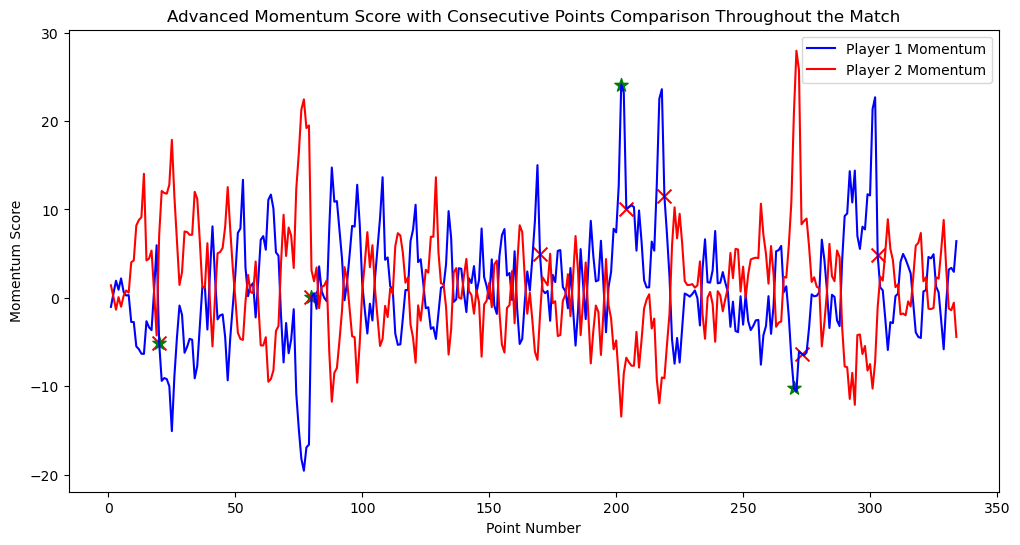

In [6]:
# Define the threshold for a significant momentum shift
threshold = 10

# Initialize lists to store the points of positive and negative shifts for both players
shifts_player_1 = []
shifts_player_2 = []

# Calculate the momentum change for each point and find shifts
for i in range(1, len(filtered_data)):
    change_1 = filtered_data['comprehensive_momentum_1'].iloc[i] - filtered_data['comprehensive_momentum_1'].iloc[i - 1]
    change_2 = filtered_data['comprehensive_momentum_2'].iloc[i] - filtered_data['comprehensive_momentum_2'].iloc[i - 1]
    
    if abs(change_1) >= threshold:
        shift_type = 'Positive' if change_1 > 0 else 'Negative'
        shifts_player_1.append((i, shift_type))
    if abs(change_2) >= threshold:
        shift_type = 'Positive' if change_2 > 0 else 'Negative'
        shifts_player_2.append((i, shift_type))

# Annotation
for point, shift_type in shifts_player_1:
    set_no = filtered_data['set_no'].iloc[point]
    game_no = filtered_data['game_no'].iloc[point]
    print(f"Player 1 had a {shift_type} shift at point number {point}, during set {set_no}, game {game_no}.")

for point, shift_type in shifts_player_2:
    set_no = filtered_data['set_no'].iloc[point]
    game_no = filtered_data['game_no'].iloc[point]
    print(f"Player 2 had a {shift_type} shift at point number {point}, during set {set_no}, game {game_no}.")
    
# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(filtered_data['point_no'], filtered_data['comprehensive_momentum_1'], label='Player 1 Momentum', color='blue')
plt.plot(filtered_data['point_no'], filtered_data['comprehensive_momentum_2'], label='Player 2 Momentum', color='red')

for point, shift_type in shifts_player_1:
    marker = '*' if shift_type == 'Positive' else 'x'
    color = 'green' if shift_type == 'Positive' else 'red'
    plt.scatter(filtered_data['point_no'].iloc[point], filtered_data['comprehensive_momentum_1'].iloc[point], 
                color=color, marker=marker, s=100)

for point, shift_type in shifts_player_2:
    marker = '*' if shift_type == 'Positive' else 'x'
    color = 'green' if shift_type == 'Positive' else 'red'
    plt.scatter(filtered_data['point_no'].iloc[point], filtered_data['comprehensive_momentum_1'].iloc[point], 
                color=color, marker=marker, s=100)
    
# Add labels and title to the plot
plt.xlabel('Point Number')
plt.ylabel('Momentum Score')
plt.title('Advanced Momentum Score with Consecutive Points Comparison Throughout the Match')
plt.legend()
plt.show()

Player 1 had a Negative shift at point number 19, during set 1, game 3.
Player 2 had a Positive shift at point number 19, during set 1, game 3.

Player 1 had a Positive shift at point number 79, during set 2, game 5.
Player 2 had a Negative shift at point number 79, during set 2, game 5.

Player 1 had a Negative shift at point number 169, during set 3, game 5.
Player 1 had a Positive shift at point number 201, during set 3, game 6.
Player 1 had a Negative shift at point number 203, during set 3, game 6.
Player 1 had a Negative shift at point number 218, during set 4, game 2.
Player 2 had a Positive shift at point number 269, during set 4, game 9.
Player 2 had a Negative shift at point number 272, during set 4, game 9.
Player 1 had a Negative shift at point number 302, during set 5, game 5.


